# Лекция 12 "Kinds & Free Monads"

__План:__
- Data type
- Kind
  - Пример про инъективность
- Free monads

## Data type

Хотим определить тип и сразу указать, что мы с ним будем делать:

```
data Expr = Val Integer
          | Var String
          | Add Expr Expr
          | Random Integer
```

Ну давайте явно укажем, что мы хотим делать:

```
eval : Expr -> Eff Integer [STDIO, EXCEPTION String, RND, STATE Env]
```

Буквально сказали: хотим работать с ИО, кидать исключения, работать с рандомом, хранить состояние (State).

## Kind

__Kind__ - это __тип типа__. Кайнды есть у всего: у __`data type`__-ов это нотация со __`*`__ и __`->`__, у __`type class`__-ов добавляется обязательный __`Constraint`__, у функций типы (строгие или полиморфные). 

Пример:

- kind __`*`__: __`Char`__, __`Bool`__, __`Char -> Bool`__, __`Maybe Int`__, __`[Int]`__
- kind __`* -> *`__: __`Maybe`__, __`[]`__
- kind __`* -> * -> *`__: __`Either`__, __`(,)`__
- Classes such as __`Show`__, __`Eq`__ or __`Ord`__ are of kind __`* -> Constraint`__. They form a class constraint when applied to types of kind __`*`__.
- Classes such as __`Functor`__ or __`Monad`__ are of kind __`(* -> *) -> Constraint`__. They form a class constraint when applied to type constructors of kind __`* -> *`__.

Даже у __`(->)`__ есть свой kind:

```
ghci> :k (->)
(->) :: * -> * -> *  -- kind of function
ghci> :k (->) Int
(->) Int :: * -> *     

-- ((->) Int) is the same as (Int -> )
```

Мы так же можем параметризовать типы типами высших порядков:

```
newtype ReaderT r (m :: * -> *) (a :: *) = ReaderT {runReaderT :: r -> m a}

ghci> :kind ReaderT
ReaderT :: * -> (* -> *) -> * -> *

ghci> :kind ReaderT String
ReaderT String :: (* -> *) -> * -> *

ghci> :kind ReaderT String IO
ReaderT String IO :: * -> *

ghci :kind ReaderT String IO Int
ReaderT String IO Int :: *
```

__class__ и __context__ не являются объектами первого порядка в Haskell. Но подключив расширение __`{-# LANGUAGE ConstraintKinds #-}`__, мы открываем для себя возможность использовать их как параметры типов. 

```
{-# LANGUAGE ConstraintKinds #-}

type MyConstraints a = (Read a, Num a, Show a)

foo :: MyConstraints a => String -> a -> a

ghci> :set -XRankNTypes 
ghci> type ConstraintEndomorphism p a = p a => a -> a
ghci> :kind ConstraintEndomorphism 
ConstraintEndomorphism :: (* -> Constraint) -> * -> *
```

С помощью __`-XTypeOperators`__ можно определять типы-операторы:

```
ghci> :set -XTypeOperators 
ghci> data a * b = Mult a b
ghci> :t (*)
(*) :: Num a => a -> a -> a
ghci> :k (*)
(*) :: * -> * -> *

ghci> let x = Mult @Int 3 True
ghci> :t x 
x :: Int * Bool

-- Defined at Data.Type.Equality
data a :~: b where
    Refl :: a :~: a
```


На самом деле способов задать кайнд очень нмного, но вот основные правила:



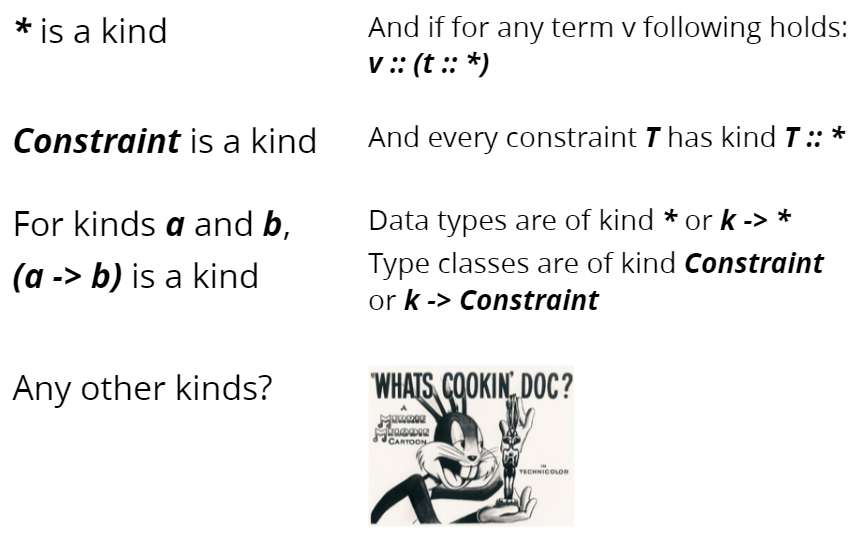

In [4]:
import IPython

print("На самом деле способов задать кайнд очень нмного, но вот основные правила:\n")
IPython.display.Image('drive/MyDrive/Exam/img/kind1.png')

Рассмотрим ещё более интересные фокусы с кайндами:

```
data Z
data S n

data Vec :: * -> * -> * where
    Nil  :: Vec a Z
    Cons :: a -> Vec a n -> Vec a (S n)
```

Из определения конструкторов понятно, что на месте средней __`*`__ может быть либо __`Z`__, либо __`(S n)`__. Хотим явно указать это компилятору, но как ?

Тут на помощь нам приходит расширение __`-XDataKinds`__ и теперь наш код будет выглядеть вот так:

```
{-# LANGUAGE DataKinds #-}

data Nat = Z | S Nat

data Vec :: * -> Nat -> * where
    Nil  :: Vec a Z
    Cons :: a -> Vec a n -> Vec a (S n)
```

Тепрь любая __data__ генерирует свой __kind__, который мы можем использовать в объявлениях. Теперь __`:kind Nat`__ может содержать только типы из конструктора __`Nat`__. Но конструктор - это не тип в обычной жизни, это функция имеющая только типы параметров и результата. Где-то здесь подвох.  
Дело в том, что __`-XDataKinds`__ решает эту проблему, добавляя каждому типовому конструктору кайнд:

```
ghci> :set -XDataKinds 
ghci> :k Succ
Succ :: Nat -> Nat

ghci> type Two = 'Succ ('Succ 'Zero) -- due to ambiguity of type and constructor
ghci> :k Two
Two :: Nat
```

Апостроф __`(')`__ помогает компилятору понять, что это __kind__, а не конструктор. И теперь нам доступна даже вот такая вот дичь:

```
ghci> :k '[]
'[] :: [k]
ghci> :k '[Int, Bool]
'[Int, Bool] :: [*]
ghci> :k '[Maybe, Either String]
'[Maybe, Either String] :: [* -> *]
ghci> :k (Int ': '[Bool])
(Int ': '[Bool]) :: [*]

```

Теперь можно написать правильную реализацию __`Vector`__-а:

```
data Vec :: * -> Nat -> * where
    Nil  :: Vec a 'Z
    (:>) :: a -> Vec a n -> Vec a ('S n)

zipV :: Vec a n -> Vec b n -> Vec (a, b) n
zipV       Nil       Nil = Nil
zipV (x :> xs) (y :> ys) = (x, y) :> zipV xs ys
```

__`zipV`__ реализована для списков одной длины, что приведёт к ошибке для списков разной длинны:

```
ghci> let x = 3    :> Nil
ghci> let y = True :> Nil
ghci> :t x
x :: Num a => Vec a ('S 'Z)
ghci> :t y
y :: Vec Bool ('S 'Z)

ghci> :t zipV x y
zipV x y :: Num a => Vec (a, Bool) ('S 'Z)

-- А вот и ошибка с длинами :( --
ghci> :t zipV x (4 :> y)
    • Couldn't match type ‘'S 'Z’ with ‘'Z’
      Expected type: Vec Bool ('S 'Z)
        Actual type: Vec Bool ('S ('S 'Z))
    • In the second argument of ‘zipV’, namely ‘(4 :> y)’
      In the expression: zipV x (4 :> y)
```

Попробуем написать гетерогенные списки (с разными типами элементов):

```
data HList :: [*] -> * where
    HNil :: HList '[]
    (:^) :: a -> HList t -> HList (a ': t)

infixr 2 :^
```

Каждое добавление элемента приводит к обновлению типа списка. А как там с типами:

```
instance Show (HList '[]) where
    show _ = "H[]"

instance (Show e, Show (HList l)) => Show (HList (e ': l)) where
    show (x :^ l) = let 'H':'[':s = show l
                    in "H[" ++ show x ++ (if s == "]" then s else ", " ++ s)

foo0 :: HList '[]
foo0 = HNil

foo1 :: HList '[Int]
foo1 = 3 :^ HNil

foo2 :: HList '[Int, Bool]
foo2 = 5 :^ False :^ HNil

ghci> foo0
H[]
ghci> foo2
H[5, False]
```

Ещё немного сахара нам в чай:

```
-- добавим типовые натуральные числа, к которым можно применять сложение --
import GHC.TypeLits

data Vec :: * -> Nat -> * where
    Nil  :: Vec a 0
    (:>) :: a -> Vec a n -> Vec a (n + 1)

ghci> :t True :> False :> Nil
True :> False :> Nil :: Vec Bool 2
```

УРА!!! мы избавились от колбасы в виде __`‘S ... ‘S ‘Z`__. 

Можно ли матчиться по типам: __МОЖНО!!!__

```
-- закрытый type family --
type family Foo bar :: * where
  Foo Char = Double
  Foo b = b
-- надо описать исчерпывающий набор патернов

-- открытый type family --
type family Foo bar :: *
type instance Foo Char = Double
type instance Foo Int = Int
-- можем описать только нужные нам паттерны
```

Ещё пример __type families__ + __data kinds__:

```
type family FromMaybe
     (m :: Maybe *) (def :: *) :: * where
  FromMaybe ('Just t) def = t
  FromMaybe 'Nothing def = def

FromMaybe ('Just Int) Bool ~ Int
```

Добавим полиморфизм к __kind__-ам:

```
{-# LANGUAGE PolyKinds #-}

type family FromMaybe
     (m :: Maybe k) (def :: k) :: k where
  FromMaybe ('Just t) def = t
  FromMaybe 'Nothing def = def
```

Также можно использовать в объявлении типов полей классов:

```
class Foo p where
  type AType p :: *
  data BType p :: *

  make :: AType p -> BType p

instance Foo Int where
  type AType Int = Int
  data BType Int = B Integer
  
  make = B . toInteger
```

### Пример про инъективность

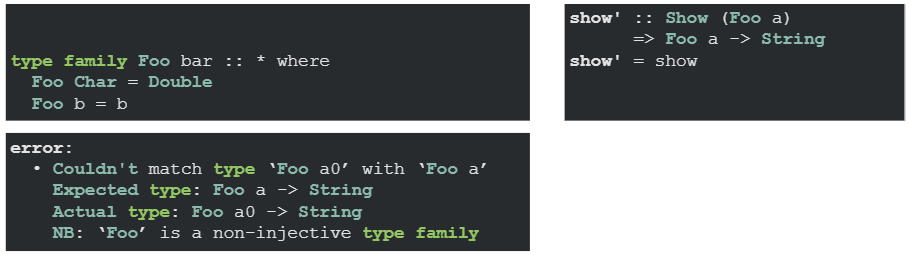

In [5]:
IPython.display.Image('drive/MyDrive/Exam/img/kind2.png')

Тут мы пытаемся в функции _`show’`_ вывести тип с помощью типовой семьи _`Foo`_. Однако сделать мы это не можем, потому что _`Foo`_ не знает, что она инъективна и может по типу справа вывести тип слева. Давайте ей это скажем:

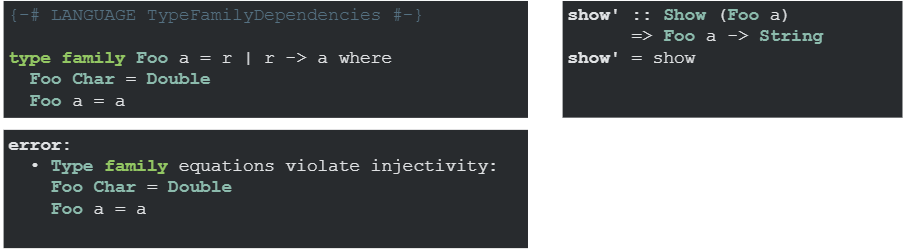

In [6]:
IPython.display.Image('drive/MyDrive/Exam/img/kind3.png')

Но компилятор не дурак, он видит, что для _`Double`_ слева может стоять как _`Char`_ так и _`Double`_. Теперь все работает:

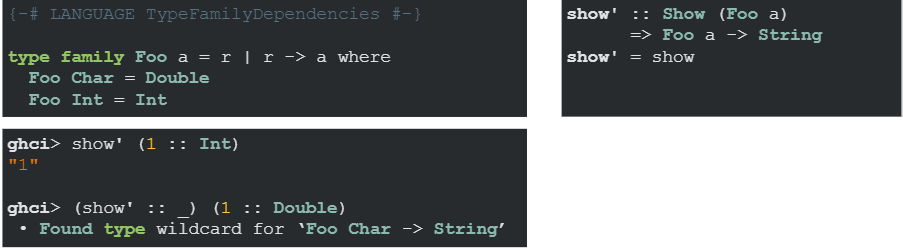

In [7]:
IPython.display.Image('drive/MyDrive/Exam/img/kind4.png')

__Способы борьбы с неинъективностью:__

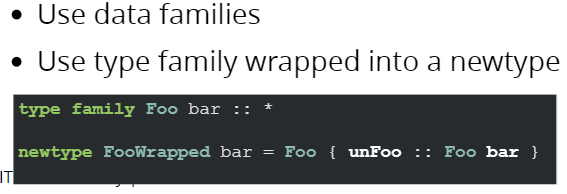

In [8]:
IPython.display.Image('drive/MyDrive/Exam/img/kind5.png')

## Free monads

Допустим мы захотели прокинуть вычисления внутрь монады, до самого дна. __`Free`__ монада нам в этом поможет:

```
data Free f a = Pure a | Free (f (Free f a))

instance Functor f => Monad (Free f) where
  return = pure

  Pure a >>= f = f a
  Free m >>= f = Free ((>>= f) <$> m)
```

- Как видно из описания: глубина вычисления __`bind`__-а (>>=) порядка глубины самой монады.
- Полезно при постройке дерева вычилений (ленивых). 
- Используют редко. 